<a href="https://colab.research.google.com/github/puaqieshang/automatic-labeling-heart-vessels/blob/master/cnn_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Update from Previous Version

* Fixed Structure of whole code
* Tuned hyperparameters and ascertain the best one using 5 fold validation

In [1]:
# Import dependencies

import os
import glob
import time
import helper
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict

import torch
from torch import tensor, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the GPU


# Data Retrieval


<table>
  <tr>
    <th>Label</th>
    <th>Class (Vessels)</th>
  </tr>
  <tr>
    <td>0</td>
    <td>LAD</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Diagonals</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Septals</td>
  </tr>
    <tr>
    <td>3</td>
    <td>LCX</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Obtuse Marginal</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Atrials</td>
  </tr>
    <tr>
    <td>6</td>
    <td>LCIM</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Acutes</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Crux</td>
  </tr>
</table>

## Import from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/processed_v2.zip"
!ls "/content/" # Lists all the files 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  __MACOSX  processed_v2  sample_data


## Split data into Train/Validate and Test 
Ensures that these 3 data are independent of each other - remove bias

*   Validation - For hyperparameter tuning and model comparison
*   Testing - For Performance Evaluation

Current ratio of Train/Validate:Test = 0.9:0.1

In [3]:
source1 = "/content/processed_v2"

test_dest = "/content/test"

if not os.path.exists(test_dest):
    os.makedirs(test_dest)

folders = os.listdir(source1)

import shutil
for folder in folders:

    if folder == ".DS_Store":
        continue

    new_folder_path = f"{test_dest}/{folder}"
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    single_folder = os.listdir(f"{source1}/{folder}")

    for f in single_folder:
        if np.random.rand(1) < 0.1: #10% of data us used for testing
            # print(f"{new_folder_path}/{f}")
            shutil.move(f"{source1}/{folder}/{f}", f"{new_folder_path}/{f}")

/content/test/8
/content/test/5
/content/test/7
/content/test/1
/content/test/2
/content/test/0
/content/test/3
/content/test/6
/content/test/4


In [4]:
def storeData(dest):

    X_all = []
    y_all = []
    folders = os.listdir(dest)
    idCount = 0

    for folder in folders:

        if (folder == ".DS_Store"):
            continue
        
        file_des = f"{dest}/{folder}"
        all_files = os.listdir(file_des)
        # print(f"Folder {folder} containes {all_files}")

        os.chdir(file_des)
        for f in glob.glob("*.txt"):
            
            geometry = np.genfromtxt(f)
            geometry = geometry.tolist()
            # print(f"The file {f} has {geometry[0]}")              
            # print(geometry.shape)
            X_all.append(geometry)
            y_all.append(folder)

            idCount = idCount +1

    X_all, y_all = shuffle(np.array(X_all), np.array(y_all), random_state=0)
    
    return X_all, y_all

dest = '/content/processed_v2/'
X_all, y_all = storeData(dest)


print(X_all.shape)
print(y_all)

(1929, 100, 4)
['6' '7' '2' ... '6' '7' '7']


## Develop Custom Dataset

In [5]:
class HeartVesselsDataset(Dataset):

    # Initialize your data, download, etc.
    def __init__(self, attributes_data, labels):

        self.x_data = attributes_data # Access dict
        self.y_data = labels # Access dict
        self.len = labels.shape[0]
        
    # USE DICTIONARY
    def __getitem__(self, index):
        # print(index)
        geometry = self.x_data[index]
        label = self.y_data[index] # Its a number
        # print(label)
        
        return geometry, tensor(int(label))


    def __len__(self):
        return len(self.x_data)



Create Validation Datasets using KFold

Cross validation (CV) is one of the technique used to test the effectiveness of a machine learning models, it is also a re-sampling procedure used to evaluate a model if we have a limited data

In [70]:
from sklearn.model_selection import KFold # import KFold
X = X_all 
print(f"Before splitting, the data has this shape - {X.shape}")
y = y_all

kf = KFold(n_splits=5,random_state=None, shuffle=False) # Define the split - into 5 folds 
# kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 

for train_index, val_index in kf.split(X):
    # print(val_index)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


print(f"\nAfter splitting, the training data has this shape - {X_train.shape}")
print(f"After splitting, the validation data has this shape - {X_val.shape}")

Before splitting, the data has this shape - (1929, 100, 4)
KFold(n_splits=5, random_state=None, shuffle=False)

After splitting, the training data has this shape - (1544, 100, 4)
After splitting, the validation data has this shape - (385, 100, 4)


In [7]:
train_dataset = HeartVesselsDataset(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=16,shuffle=True,num_workers=0)

val_dataset = HeartVesselsDataset(X_val, y_val)
valloader = DataLoader(dataset=val_dataset, batch_size=16,shuffle=True,num_workers=0)

print(f"Train has {len(trainloader)} batches and {train_dataset.len} datasets")
print(f"Validation has {len(valloader)} batches and {val_dataset.len} datasets")


Train has 97 batches and 1544 datasets
Validation has 25 batches and 385 datasets


## Inspecting Input - A Single Branch

A Random Coronary Branch
Dimension of a branch/matrix is torch.Size([100, 4])


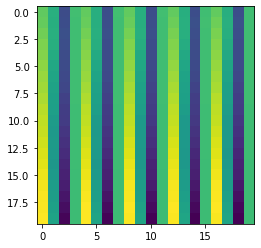

The label is 1


In [8]:
geometries, label = next(iter(trainloader))

# print(f"Geo is of type {geometries.type}")
# print(f"Label is of type {label.type}")
print("A Random Coronary Branch")
print(f"Dimension of a branch/matrix is {geometries[0].shape}")

plt.imshow(geometries[0].view(20, 20))
plt.show()
print(f"The label is {label[0]}")

# Model Definition

So that different model architectures can work interchangeable



## Linear Layers

### Model 1 - nn.Linear in Sequential Form

A simple Multi-Layer Perceptron, but achieves accuracy of 0.78 - 0.8 after 350 epochs

In [ ]:
# model = nn.Sequential(nn.Linear(400,128), nn.ReLU(), nn.Linear(128,64), 
#                       nn.ReLU(), nn.Linear(64,9), nn.LogSoftmax(dim=1))

# model = model.to(device)

### Model 2 - nn.Linear in Class form 
Basically same as Model 1, just that its in nn.functional() form. This allows user to tune the parameters more, which is better. 


In [ ]:
# # Start Timer
# t0 = time.time()


# class ConvNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Defining the layers, 128, 64, 9 units each
#         self.fc1 = nn.Linear(400, 128)
#         self.fc2 = nn.Linear(128, 64)
#         # Output layer, 9 units - one for each digit
#         self.fc3 = nn.Linear(64, 9)
        
#     def forward(self, x):
#         ''' Forward pass through the network, returns the output logits '''
        
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.log_softmax(x, dim=1)
        
#         return x


# model = ConvNN()
# model = model.to(device)

## Convolutional Layers

Suggestions to Improve:
* Use He Initialization for ReLU layers instead of random or zero initiliazation. Refer to roadmap
* Use more regularization techniques (if necessary)

Things to note:
* Increasing number of layers by more than 2 do not improve the accuracy - could be due to my model being simple?
* No need to have a lot of nodes in a hidden layer; the input is not a 2D image anyways.
* [Dropout Layers FAQ ](https://https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network )
* Dropout layers may result in [Test Accuracy > Train Accuracy](https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy)  

### Model 3 - Conv1D with 3 Hidden Layers

Comment out the Regularisation if not needed



In [9]:
class ConvNN(nn.Module):


    def __init__(self):
        super().__init__()
        
        # Input Tensor [batch, in_channels, in_width]
        x = torch.randn(100, 4).view(-1, 4, 100)    # replace with He initialization
        # print(x.shape)

        # Defining the layers, 4, 8, 16 and 32 units each
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3)

        # Activated during eval mode
        self.conv1_bn = nn.BatchNorm1d(16)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.conv3_bn = nn.BatchNorm1d(256)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(32)
    
        self.fc_dropout = nn.Dropout(p=0.5)
        self.conv_dropout = nn.Dropout(p=0.1)
        
        self._to_linear = None
        # Time distributed layer - maybe change to keras
        self.convs(x)
        
        # self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
        # self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

        self.fc1 = nn.Linear(self._to_linear, 128) #flattening.
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 9)

    def convs(self, x):
        # max pooling over 2
        
        x = self.conv1(x)
        x = self.conv1_bn(x)  
        x = F.relu(x)
        x = self.conv_dropout(x)    
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv2(x)
        x = self.conv2_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu

        x = self.conv3(x)
        x = self.conv3_bn(x)   
        x = F.relu(x)
        x = self.conv_dropout(x)
        x = F.max_pool1d(x, 2) #or Elu
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
            
        return x
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.convs(x)
        # .view is reshape ... this flattens X before going to FC layer
        x = x.view(-1, self._to_linear)  

        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x) 

        x = self.fc2(x) # bc this is our output layer. No activation here.
        x = self.fc2_bn(x)
        x = F.relu(x)
        x = self.fc_dropout(x)   

        x = self.fc3(x)

        return F.log_softmax(x, dim=1)
        
        return x


### Model 4 - Conv1D with 2 Layers

The node layers and numbers are based on multiple websites:
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://www.researchgate.net/post/In_neural_networks_model_which_number_of_hidden_units_to_select


In [ ]:
# class ConvNN(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # Input Tensor [batch, in_channels, in_width]
#         x = torch.randn(100, 4).view(-1, 4, 100)
#         print(x.shape)

        
#         self.conv1 = nn.Conv1d(in_channels=4, out_channels=7, kernel_size=3) 
#         self.conv2 = nn.Conv1d(in_channels=7, out_channels=5, kernel_size=3)
#         # self.conv1_bn = nn.BatchNorm1d(7)
#         # self.conv2_bn = nn.BatchNorm1d(5)
#         self.fc_dropout = nn.Dropout(p=0.5)
#         self.conv_dropout = nn.Dropout(p=0.1)
        
#         self._to_linear = None

#         self.convs(x)

#         self.fc1 = nn.Linear(self._to_linear, 64) #flattening.
#         self.fc2 = nn.Linear(64, 9) # 64 in, 9out bc we're doing 9 classes 

#     def convs(self, x):
#         # max pooling over 2
#         x = self.conv1(x)
#         # x = self.conv1_bn(x)       
#         x = F.max_pool1d(self.conv_dropout(F.relu(x)), 2) #or Elu

#         x = self.conv2(x)
#         # x = self.conv2_bn(x)       
#         x = F.max_pool1d(self.conv_dropout(F.relu(x)), 2) #or Elu

#         # x = self.conv3(x)
#         # # x = self.conv3_bn(x)       
#         # x = F.max_pool1d(F.relu(x), 2) #or Elu
        
#         if self._to_linear is None:
#             self._to_linear = x[0].shape[0]*x[0].shape[1]
            
#         return x
        
#     def forward(self, x):
#         ''' Forward pass through the network, returns the output logits '''
        
#         x = self.convs(x)
#         x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 

#         x = self.fc1(x)
#         # x = self.fc1_bn(x)
#         x = F.relu(x)
#         x = self.fc_dropout(x) 

#         x = self.fc2(x) # bc this is our output layer. No activation here.
#         return F.log_softmax(x, dim=1)
        
#         return x


# Train and Validate Model




```
model.train(), model.eval()
```

Both are the same. By default all the modules are initialized to train mode (self.training = True). 

In case you want to validate your data, call model.eval() before feeding the data, as this will change the behavior of the BatchNorm (or Dropout) layer to use the running estimates instead of calculating them for the current batch.
If you want to train your model and can’t use a bigger batch size, you could switch e.g. to InstanceNorm.

In [10]:
def train(loader): # for train cases
    running_loss = 0
    sumCorrect = 0
    sumTotal = 0      

    model.train() # for train cases
        
    for X, y in loader:

        X = X.view(-1, 4, 100)
        # print(X.shape)
        X, y = X.to(device), y.to(device)
        
        optimiser.zero_grad()
        
        # train_X = train_X.view(-1, 4, 100)
        output = model(X.float())
        _, predicted = torch.max(output.data, 1)
        loss = criterion(output,y)

        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        
        # Accuracy
        sumCorrect += (predicted == y).sum().item()
        sumTotal += y.size(0)

    l = running_loss/len(loader) #average loss for whole loader dataset
    acc = sumCorrect/sumTotal

    return acc, l

def validate(loader):
    running_loss = 0
    sumCorrect = 0
    sumTotal = 0      

    model.eval() # for validation cases
    with torch.no_grad():   
        for X, y in loader:

            X = X.view(-1, 4, 100)
            # print(X.shape)
            X, y = X.to(device), y.to(device)
            
            
            # train_X = train_X.view(-1, 4, 100)
            output = model(X.float())
            _, predicted = torch.max(output.data, 1)
            loss = criterion(output,y)

            running_loss += loss.item()         

            # Accuracy
            sumCorrect += (predicted == y).sum().item()
            sumTotal += y.size(0)
            # print(sumTotal)   

    l = running_loss/len(loader) #average loss for whole loader dataset
    acc = sumCorrect/sumTotal

    return acc, l

def train_and_validate(trainloader, valloader):
    train_acc_list, train_loss_list, val_acc_list, val_loss_list = [],[],[],[]
    
    for e in tqdm(range(EPOCHS), position=0, leave=True):

        # Train
        train_acc, train_loss = train(trainloader)
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        # Validate
        val_acc, val_loss = validate(valloader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
    
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [11]:
model = ConvNN()
model = model.to(device)

## Calculate Accuracy and Loss - *Testing (Not the Main Program)*

In [12]:
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Refer to Deep Learning Roadmap

EPOCHS = 5
train_acc_total, train_loss_total, val_acc_total, val_loss_total = [],[],[],[]
for i in range(4):
    
    a, b, c, d = train_and_validate(trainloader, valloader)
  
    train_acc_total.append(a)
    train_loss_total.append(b) 
    val_acc_total.append(c) 
    val_loss_total.append(d) 

t1 = time.time()
duration = (t1-t0)/60
print("\nTime taken to train is " + "{:.2f}".format(duration) + " minutes.")

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Time taken to train is 0.31 minutes.


# Visualization



## See Validation Results for 1 Sample

The actual vessel is obtmar


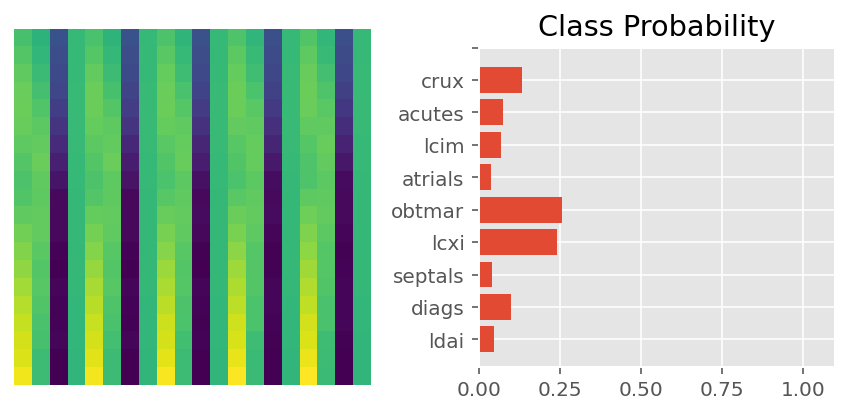

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']


dataiter = iter(valloader)
geometries, labels = dataiter.next()
geom = geometries[0]
# Convert 2D matrix/image to 1D vector

geom = geom.resize_(1, 400)


# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    
    logps = model(geom.cuda().view(-1, 4, 100).float()) # convert to cuda tensor to run faster
    
ps = torch.exp(logps)

# Plot the image and probabilities

def view_classify(geom, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(geom.resize_(20, 20).numpy().squeeze()) #First figure on left
    
    ax1.axis('off')
    ax2.barh(np.arange(9), ps) #Make a horizontal bar plot
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(vessels_names, size='medium');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


geom_numpy = geom.cpu().numpy()
view_classify(geom.reshape(20, 20), ps) # convert back to numpy

print(f"The actual vessel is {vessels_names[labels[0]]}")


## Plot Accuracies and Loss vs Epochs

This fucntion is used to average the train and validation accuracy and loss. It won't be useful if we are tying to tune the hyperparameters

In [13]:

def averaging(train_acc_total, train_loss_total, val_acc_total, val_loss_total):

    train_acc_total = np.asarray(train_acc_total)
    train_loss_total = np.asarray(train_loss_total)
    val_acc_total = np.asarray(val_acc_total)
    val_loss_total = np.asarray(val_loss_total)

    # print(train_acc_total)
    firstRow = train_acc_total[:, 0]
    # print(firstRow)
    # print(np.average(firstRow))

    train_acc_avg, train_loss_avg, val_acc_avg, val_loss_avg =[], [],[],[]

    for i in range(train_acc_total.shape[1]):
        mean_acc = np.average(train_acc_total[:, i])
        train_acc_avg.append(mean_acc)

        mean_loss = np.average(train_loss_total[:, i])
        train_loss_avg.append(mean_loss)

        mean_acc = np.average(val_acc_total[:, i])
        val_acc_avg.append(mean_acc)

        mean_loss = np.average(val_loss_total[:, i])
        val_loss_avg.append(mean_loss)

    return train_acc_avg, train_loss_avg, val_acc_avg, val_loss_avg

Average Accuracy and Loss for Train and Val

In [58]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

style.use("ggplot")

def create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list):
    epoch = list(range(0, EPOCHS, 1))

    d = {'epochs': epoch,
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'val_acc': val_acc_list, 
        'val_loss': val_loss_list}

    df = pd.DataFrame(d)

    df['train_acc_avg'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
    df['val_acc_avg'] = df['val_acc'].ewm(alpha=.02).mean()
    df['train_loss_avg'] = df['train_loss'].ewm(alpha=.02).mean()
    df['val_loss_avg'] = df['val_loss'].ewm(alpha=.02).mean()

    # Then plot using pandas:
    df.plot(x='epochs', y=['train_acc_avg', 'val_acc_avg'], figsize=(8,4))
    plt.ylabel("Accuracy")
    df.plot(x='epochs', y=['train_loss_avg', 'val_loss_avg'], figsize=(8,4))
    plt.ylabel("Loss")

    plt.show()



## Compare Validation Sets

Validation Set is used to compare diff models and tune hyperparamters to get the optimum one.



In [42]:
from scipy.interpolate import make_interp_spline, BSpline

def compare_graph(x, y, parameter, compare):

    plt.figure()

    for i in range(len(x)):

        # 300 represents number of points to make between T.min and T.max
        # x_smooth = np.linspace(min(x[i]), max(x[i]), 300)  
        # spline = make_interp_spline(x[i], y[i], k=3)
        # y_smooth = spline(x_smooth)
        # plt.plot(x_smooth, y_smooth, label=f"learning rate = {parameter[i]}")

        plt.plot(x[i], y[i], label=f"learning rate = {parameter[i]}")
    
    plt.xlabel('Epochs')
    
    if compare is "acc":
        plt.ylabel('Accuracy')
        plt.legend(loc="lower right")
    else:
        plt.ylabel('Loss')
        plt.legend(loc="upper right")
    
    plt.show()


# Main Pipeline
24/6/2020 - Curerntly used for hyperparameter tuning through Five-fold cross validation


  0%|          | 0/200 [00:00<?, ?it/s]


Time taken to train for 1 validation set is 6.18 minutes.


  0%|          | 0/200 [00:00<?, ?it/s]


Time taken to train for 1 validation set is 3.12 minutes.


  0%|          | 0/200 [00:00<?, ?it/s]


Time taken to train for 1 validation set is 1.64 minutes.


  0%|          | 1/200 [00:00<00:32,  6.17it/s]


Time taken to train for 1 validation set is 0.88 minutes.


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]



Time taken to train for 1 validation set is 0.54 minutes.


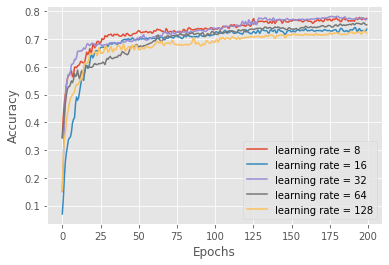

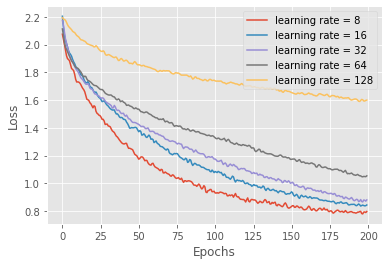

In [64]:
import statistics as stats

accuracies = []

learningRate = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch = [8, 16, 32, 64, 128]


X = X_all 
y = y_all # Create another array
kf = KFold(n_splits=5,random_state=None, shuffle=False) # shuffle was fale

train_acc_total, train_loss_total, val_acc_total, val_loss_total = [],[],[],[]
epochs_total=[]

i = 0
for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_dataset = HeartVesselsDataset(X_train, y_train)
    trainloader = DataLoader(dataset=train_dataset, batch_size=batch[i],shuffle=True,num_workers=0)

    val_dataset = HeartVesselsDataset(X_val, y_val)
    valloader = DataLoader(dataset=val_dataset, batch_size=batch[i],shuffle=True,num_workers=0)

    model = ConvNN()
    model = model.to(device)

    t0 = time.time()
    criterion = nn.NLLLoss()
    optimiser = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)

    EPOCHS = 200# at least 5 for the interpoaltion to work
    e = list(range(0, EPOCHS))

    train_acc_list, train_loss_list, val_acc_list, val_loss_list = train_and_validate(trainloader, valloader)
    
    train_acc_total.append(train_acc_list)
    train_loss_total.append(train_loss_list) 
    val_acc_total.append(val_acc_list) 
    val_loss_total.append(val_loss_list) 
    epochs_total.append(e)

    t1 = time.time()
    duration = (t1-t0)/60
    print("\nTime taken to train for 1 validation set is " + "{:.2f}".format(duration) + " minutes.")

    i+= 1

compare_graph(epochs_total, val_acc_total, batch, compare="acc")
compare_graph(epochs_total, val_loss_total, batch, compare="loss")

# To get acc and loss for both val and test
# a,b,c,d = averaging(train_acc_total, train_loss_total,  val_acc_total, val_loss_total)
# create_acc_loss_graph(a,b,c,d )

# print(f"\nThis model has an accuracy of {round(max(accuracies), 3)} +/- {round(stats.stdev(accuracies), 3)}")      

# Training on Most Optimum Model

100%|██████████| 200/200 [03:09<00:00,  1.06it/s]



Time taken to train for 1 validation set is 3.15 minutes.


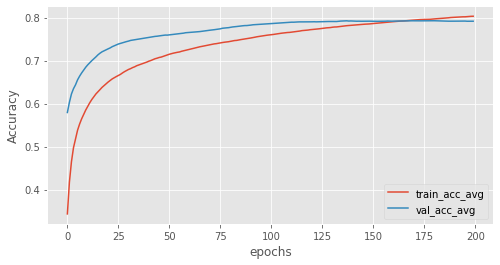

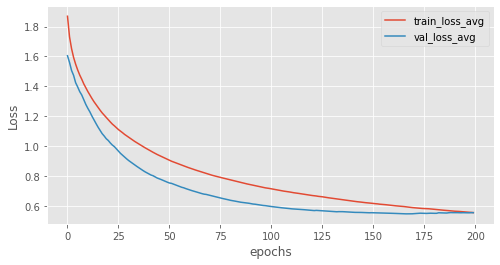

TypeError: ignored

In [85]:
import statistics as stats

accuracies = []

learningRate = 0.0001
batch = 16


X = X_all 
y = y_all # Create another array

train_ratio = 0.8

train_index = list(range(0, int(train_ratio*len(X))))
val_index = list(range(int(train_ratio*len(X)), len(X)-1))

X_train, X_val = X[train_index], X[val_index]
y_train, y_val = y[train_index], y[val_index]

train_dataset = HeartVesselsDataset(X_train, y_train)
trainloader = DataLoader(dataset=train_dataset, batch_size=batch,shuffle=True,num_workers=0)

val_dataset = HeartVesselsDataset(X_val, y_val)
valloader = DataLoader(dataset=val_dataset, batch_size=batch,shuffle=True,num_workers=0)

model = ConvNN()
model = model.to(device)

t0 = time.time()
criterion = nn.NLLLoss()
optimiser = optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-4)

EPOCHS = 200# at least 5 for the interpoaltion to work

train_acc_list, train_loss_list, val_acc_list, val_loss_list = train_and_validate(trainloader, valloader)

t1 = time.time()
duration = (t1-t0)/60
print("\nTime taken to train for 1 validation set is " + "{:.2f}".format(duration) + " minutes.")

create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list)

# To get acc and loss for both val and test
# a,b,c,d = averaging(train_acc_total, train_loss_total,  val_acc_total, val_loss_total)
# create_acc_loss_graph(a,b,c,d )

print(f"\nThis model has an accuracy of {round(val_acc_list[-1], 3)} and loss of {round(val_loss_list[-1], 3)}")      

# Test Model on Unseen Data 
Well technically, `model.eval() `is not learning any new weights so its testing

In [86]:
# !rm -r /content/test
dest = '/content/test/'
X_test, y_test = storeData(dest)

test_dataset = HeartVesselsDataset(X_test, y_test)
testloader = DataLoader(dataset=test_dataset, batch_size=16,shuffle=True,num_workers=0)

In [87]:
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']

def test(model):

    correct = 0
    total = 0
    vessels_count = np.zeros((9,), dtype=int)
    vessels_correct = np.zeros((9,), dtype=int)
    mainBifurcations_count = np.zeros((3,), dtype=int) 
    mainBifurcations_correct = np.zeros((3,), dtype=int) 

    predicted_class_array = []
    true_class_array = []

    with torch.no_grad():

        model.eval()

        for test_X, test_y in testloader:

            test_y_list = test_y.tolist()
            # true_class_array.append(test_y)
            true_class_array.extend(test_y_list)
            test_X, test_y = test_X.to(device), test_y.to(device)

            for i in tqdm(range(len(test_X)), position=0, leave=True):
                real_class = test_y[i].item()
                # print(f"real class is {real_class}")

                vessels_count[real_class] += 1
                # ps = net(test_X[i].view(-1, 1, 20, 20))[0] 
                geom = test_X[i]
                geom = geom.view(-1, 4, 100)
                    
                logps = model(geom.float())
                ps = torch.exp(logps)  #probabilities
                predicted_class = torch.argmax(ps).item()
                predicted_class_array.append(predicted_class)

                if predicted_class is real_class:
                    vessels_correct[real_class] += 1
                    correct += 1
                
                else: 
                    # These numbers follow the sequence in the "vessels_name" list
                    # print(predicted_class)
                    if predicted_class in {0, 1, 2}: 
                        
                        if real_class in {0, 1, 2}:
                            # print(f"predicted {predicted_class}, real {real_class}")
                            mainBifurcations_correct[0] += 1

                    elif predicted_class in {3, 4}:
                        if real_class in {3, 4}:
                            # print(f"predicted {predicted_class}, real {real_class}")
                            mainBifurcations_correct[1] += 1
                    
                    elif predicted_class in {7, 8}:
                        if real_class in {7, 8}:
                            mainBifurcations_correct[2] += 1
                    else: 
                        continue

                total += 1

    print("\n\nOverall Accuracy is:", round(correct/total,3))
    print("------------------------")

    for i in range(len(vessels_count)):
        acc = round(vessels_correct[i]/vessels_count[i],3)
        string = f"Accuracy of {vessels_names[i]} is:"
        print("{:<30} {:<5}".format(string, acc))

    print("------------------------")
    print(f"No of samples for each vessel in a batch is {vessels_count}")

    mainBifurcations_count[0] = vessels_count[0] + vessels_count[1] + vessels_count[2] #LCA
    mainBifurcations_count[1] = vessels_count[3] + vessels_count[4] #LCX
    mainBifurcations_count[2] = vessels_count[7] + vessels_count[8] #RCA 

    mainBifurcations_correct[0] += vessels_correct[0] + vessels_correct[1] + vessels_correct[2]  #LCA
    mainBifurcations_correct[1] += vessels_correct[3] + vessels_correct[4]  #LCX
    mainBifurcations_correct[2] += vessels_correct[7] + vessels_correct[8]  #RCA

    print("------------------------")
    print(f"Bifurcation LCA has accuracy of {round(mainBifurcations_correct[0]/mainBifurcations_count[0], 3)}")
    print(f"Bifurcation LCX has accuracy of {round(mainBifurcations_correct[1]/mainBifurcations_count[1], 3)}")
    print(f"Bifurcation RCA has accuracy of {round(mainBifurcations_correct[2]/mainBifurcations_count[2], 3)}")

    # print(test_y)
    return true_class_array, predicted_class_array


true_class_array, predicted_class_array = test(model)


100%|██████████| 3/3 [00:00<00:00, 401.71it/s]



Overall Accuracy is: 0.798
------------------------
Accuracy of ldai is:           0.788
Accuracy of diags is:          0.909
Accuracy of septals is:        0.5  
Accuracy of lcxi is:           0.645
Accuracy of obtmar is:         0.789
Accuracy of atrials is:        0.0  
Accuracy of lcim is:           0.333
Accuracy of acutes is:         0.867
Accuracy of crux is:           0.92 
------------------------
No of samples for each vessel in a batch is [33 33  2 31 19  3  9 15 50]
------------------------
Bifurcation LCA has accuracy of 0.971
Bifurcation LCX has accuracy of 0.94
Bifurcation RCA has accuracy of 0.985


# Analysis 

## Confusion Matrix

In [1]:
from sklearn import metrics

# True values
y_true = true_class_array
# Predicted values
y_pred = predicted_class_array

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))


NameError: ignored

In [83]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.955     0.636     0.764        33
           1      0.579     1.000     0.733        33
           2      0.000     0.000     0.000         2
           3      0.622     0.903     0.737        31
           4      0.429     0.158     0.231        19
           5      0.000     0.000     0.000         3
           6      0.000     0.000     0.000         9
           7      0.789     1.000     0.882        15
           8      1.000     0.900     0.947        50

    accuracy                          0.744       195
   macro avg      0.486     0.511     0.477       195
weighted avg      0.717     0.744     0.704       195



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Appendix A - Displays Model Information

In [49]:
from torchvision import models
model = models.vgg16()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [50]:
# Prints the model's state for each layer
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print the weights of the model - A LOT OF MATRICES
# print("Optimizer's state_dict:")
# for var_name in optimiser.state_dict():
#     print(var_name, "\t", optimiser.state_dict()[var_name])

Model's state_dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.2.weight 	 torch.Size([64, 64, 3, 3])
features.2.bias 	 torch.Size([64])
features.5.weight 	 torch.Size([128, 64, 3, 3])
features.5.bias 	 torch.Size([128])
features.7.weight 	 torch.Size([128, 128, 3, 3])
features.7.bias 	 torch.Size([128])
features.10.weight 	 torch.Size([256, 128, 3, 3])
features.10.bias 	 torch.Size([256])
features.12.weight 	 torch.Size([256, 256, 3, 3])
features.12.bias 	 torch.Size([256])
features.14.weight 	 torch.Size([256, 256, 3, 3])
features.14.bias 	 torch.Size([256])
features.17.weight 	 torch.Size([512, 256, 3, 3])
features.17.bias 	 torch.Size([512])
features.19.weight 	 torch.Size([512, 512, 3, 3])
features.19.bias 	 torch.Size([512])
features.21.weight 	 torch.Size([512, 512, 3, 3])
features.21.bias 	 torch.Size([512])
features.24.weight 	 torch.Size([512, 512, 3, 3])
features.24.bias 	 torch.Size([512])
features.26.weight 	 torch.Size([512, 5

In [51]:

total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The total params are {total_params} and the trainable one are {trainable_params}")


The total params are 138357544 and the trainable one are 138357544
